In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, hamming_loss, f1_score
from gensim.models import Word2Vec

In [4]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

df = pd.read_csv('data/mLabel_tweets.csv')
df['tokens'] = df['tweet'].apply(clean_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df['label_list'] = df['labels'].apply(lambda x: str(x).split(' '))
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['label_list'])
print(f"Labels: {mlb.classes_}")

Labels: ['conspiracy' 'country' 'ineffective' 'ingredients' 'mandatory' 'none'
 'pharma' 'political' 'religious' 'rushed' 'side-effect' 'unnecessary']


In [6]:
X_train_tokens, X_test_tokens, y_train, y_test = train_test_split(
    df['tokens'], y, test_size=0.2, random_state=42
)

In [7]:
print("\nTraining Word2Vec...")
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=2, workers=4)

print("Loading GloVe...")
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
except FileNotFoundError:
    print("WARNING: 'glove.6B.100d.txt' not found. GloVe models will fail.")


Training Word2Vec...
Loading GloVe...


In [8]:
def get_vector(tokens, model_dict, vector_size):
    valid_vectors = [model_dict[word] for word in tokens if word in model_dict]
    if not valid_vectors:
        return np.zeros(vector_size)
    return np.mean(valid_vectors, axis=0)

print("Vectorizing data...")
X_train_w2v = np.array([get_vector(t, w2v_model.wv, 100) for t in X_train_tokens])
X_test_w2v = np.array([get_vector(t, w2v_model.wv, 100) for t in X_test_tokens])

Vectorizing data...


In [9]:
if embeddings_index:
    X_train_glove = np.array([get_vector(t, embeddings_index, 100) for t in X_train_tokens])
    X_test_glove = np.array([get_vector(t, embeddings_index, 100) for t in X_test_tokens])
else:
    X_train_glove, X_test_glove = None, None

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, multilabel_confusion_matrix, roc_curve, auc

results = {}

models_config = [
    ("LR + Word2Vec", LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42), X_train_w2v, X_test_w2v),
    ("MLP + Word2Vec", MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42), X_train_w2v, X_test_w2v),
    ("LR + GloVe", LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42), X_train_glove, X_test_glove),
    ("MLP + GloVe", MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42), X_train_glove, X_test_glove)
]

In [11]:
for name, base_clf, X_tr, X_te in models_config:
    if X_tr is None:
        continue
        
    print(f"Processing {name}...")
    
    clf = MultiOutputClassifier(base_clf)
    clf.fit(X_tr, y_train)
    
    y_pred = clf.predict(X_te)
    
    try:
        probas_list = clf.predict_proba(X_te)
        y_score = np.array([p[:, 1] if p.shape[1] == 2 else np.zeros(p.shape[0]) for p in probas_list]).T
    except:
        y_score = np.zeros_like(y_pred) # Fallback if proba fails


    acc = accuracy_score(y_test, y_pred)
    ham = hamming_loss(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    
    print(f"Accuracy:     {acc:.4f}")
    print(f"Hamming Loss: {ham:.4f}")
    print(f"F1 Score:     {f1:.4f}")

    results[name] = {'y_pred': y_pred, 'y_score': y_score}

Processing LR + Word2Vec...
Accuracy:     0.1879
Hamming Loss: 0.0895
F1 Score:     0.2967
Processing MLP + Word2Vec...
Accuracy:     0.1753
Hamming Loss: 0.0898
F1 Score:     0.2895
Processing LR + GloVe...
Accuracy:     0.3184
Hamming Loss: 0.0806
F1 Score:     0.4698
Processing MLP + GloVe...


c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy:     0.3471
Hamming Loss: 0.0882
F1 Score:     0.5207


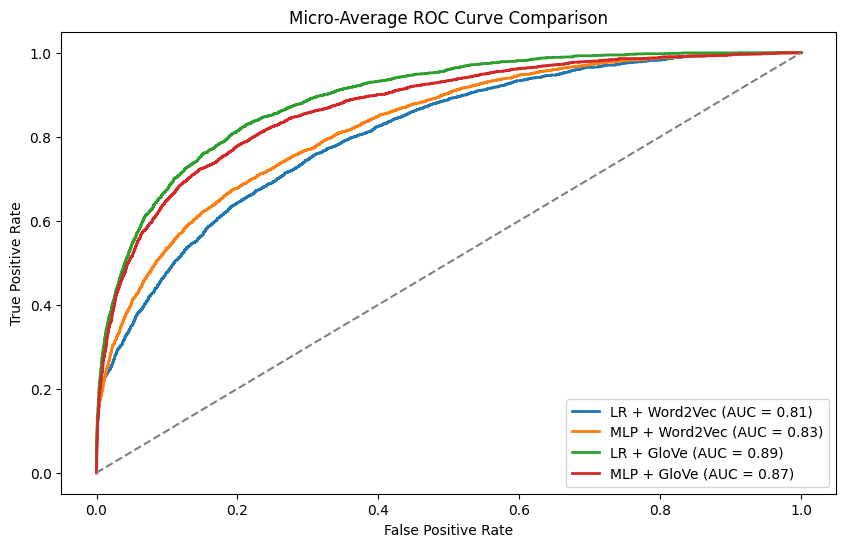

In [12]:
plt.figure(figsize=(10, 6))
for name, data in results.items():
    fpr, tpr, _ = roc_curve(y_test.ravel(), data['y_score'].ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

In [13]:
for name, data in results.items():
    print(f"\n{'='*40}")
    print(f"Model: {name}")
    print(f"{'='*40}")
    print(classification_report(y_test, data['y_pred'], target_names=mlb.classes_, zero_division=0))


Model: LR + Word2Vec
              precision    recall  f1-score   support

  conspiracy       0.50      0.01      0.02        91
     country       0.00      0.00      0.00        39
 ineffective       0.60      0.01      0.02       342
 ingredients       0.00      0.00      0.00       114
   mandatory       0.00      0.00      0.00       155
        none       0.00      0.00      0.00       115
      pharma       0.48      0.04      0.08       258
   political       0.00      0.00      0.00       110
   religious       0.00      0.00      0.00        13
      rushed       1.00      0.01      0.01       298
 side-effect       0.80      0.57      0.66       764
 unnecessary       0.00      0.00      0.00       160

   micro avg       0.78      0.18      0.30      2459
   macro avg       0.28      0.05      0.07      2459
weighted avg       0.52      0.18      0.22      2459
 samples avg       0.23      0.21      0.21      2459


Model: MLP + Word2Vec
              precision    recall 